In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
import pickle
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import permutation_importance

# Create a directory for saving models and scaler
if not os.path.exists('model_data'):
    os.makedirs('model_data')

# Create a directory for output images if it does not exist
if not os.path.exists('output_images'):
    os.makedirs('output_images')


def load_data(data_path, training_data_name):
    # Load the dataset
    data = pd.read_csv(data_path)

    # Split the data into X (the input features) and y (the target)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Save feature names
    feature_names = X.columns.tolist()
    joblib.dump(feature_names, f'model_data/{training_data_name}/feature_names.pkl')

    return X, y


def scale_and_split_data(X, y, training_data_name, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Save the trained scaler
    joblib.dump(scaler, f'model_data/{training_data_name}/trained_scaler.pkl')

    return X_train_scaled, X_test_scaled, y_train, y_test


def train_logreg(X_train_scaled, y_train, training_data_name):
    logreg = LogisticRegression(random_state=42)
    param_grid = {
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear'],
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]  # Inverse of regularization strength
    }

    param_grid_l1 = {
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]  # Inverse of regularization strength
    }

    param_grid_elasticnet = {
        'solver': ['saga'],
        'penalty': ['elasticnet'],
        'l1_ratio': [i / 10.0 for i in range(11)],  # Increments of 0.1 from 0 to 1
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]  # Inverse of regularization strength
    }

    param_grid = [param_grid, param_grid_l1, param_grid_elasticnet]
    grid = GridSearchCV(logreg, param_grid, cv=5, verbose=True, n_jobs=-1)

    grid.fit(X_train_scaled, y_train)
    # Save the trained model
    model_file = f'model_data/{training_data_name}/trained_model_logreg.pkl'
    if os.path.exists(model_file):
        overwrite = input("Model file already exists. Do you want to overwrite it? (yes/no) ")
        if overwrite.lower() != "yes":
            return
    joblib.dump(grid.best_estimator_, f'model_data/{training_data_name}/trained_model_logreg.pkl')

    return grid.best_estimator_


def load_model_and_scaler(model_file, scaler_file):
    # Load the model and scaler
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)

    return model, scaler


def train_svm(X_train_scaled, y_train, training_data_name):
    svm = SVC(random_state=42,probability=True)
    # Define the parameter grid for SVM
    param_grid = {'C': [0.1, 1, 10, 100, 1000],
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

    grid = GridSearchCV(svm, param_grid, refit=True, verbose=3)

    grid.fit(X_train_scaled, y_train)

    model_file = f'model_data/{training_data_name}/trained_model_svm.pkl'
    if os.path.exists(model_file):
        overwrite = input("Model file already exists. Do you want to overwrite it? (yes/no) ")
        if overwrite.lower() != "yes":
            return

    joblib.dump(grid.best_estimator_, f'model_data/{training_data_name}/trained_model_svm.pkl')
    return grid.best_estimator_


def train_rf(X_train_scaled, y_train, training_data_name):
    rf = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [10, 50, 100, 200],  # The number of trees in the forest
        'max_features': ['sqrt', 'log2'],  # The number of features to consider when looking for the best split
        'max_depth': [None, 10, 20, 30, 40, 50],  # The maximum depth of the tree
        'min_samples_split': [2, 5, 10],  # The minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4],  # The minimum number of samples required to be at a leaf node
        'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
    }
    grid = GridSearchCV(rf, param_grid, cv=5, verbose=True, n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    model_file = f'model_data/{training_data_name}/trained_model_rf.pkl'
    if os.path.exists(model_file):
        overwrite = input("Model file already exists. Do you want to overwrite it? (yes/no) ")
        if overwrite.lower() != "yes":
            return

    joblib.dump(grid.best_estimator_, f'model_data/{training_data_name}/trained_model_rf.pkl')
    return grid.best_estimator_


def train_ensemble(X_train_scaled, y_train, training_data_name):
    # Load the trained models and scalers
    svm = joblib.load(f'model_data/{training_data_name}/trained_model_svm.pkl')
    rf = joblib.load(f'model_data/{training_data_name}/trained_model_rf.pkl')
    log_reg = joblib.load(f'model_data/{training_data_name}/trained_model_logreg.pkl')

    # Create a list of tuples, each tuple containing the string identifier and the model
    models = [('svm', svm), ('rf', rf), ('log_reg', log_reg)]

    # Create the ensemble model
    ensemble = VotingClassifier(estimators=models, voting='soft')

    # Fit the ensemble model on the scaled training data
    ensemble.fit(X_train_scaled, y_train)
    model_file = f'model_data/{training_data_name}/trained_model_ensemble.pkl'
    if os.path.exists(model_file):
        overwrite = input("Model file already exists. Do you want to overwrite it? (yes/no) ")
        if overwrite.lower() != "yes":
            return
    joblib.dump(ensemble, f'model_data/{training_data_name}/trained_model_ensemble.pkl')
    return ensemble


def make_prediction(model, X_test_scaled):
    # Make predictions
    y_pred = model.predict(X_test_scaled)

    return y_pred

# Start with Correlation Matrices 

In [10]:
def plot_correlation_matrix(X, title):
    corr = X.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 20))  # Increase the size of the figure

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    ax.set_title(title)  # Set the title for the diagram

    plt.subplots_adjust(bottom=0.28)  # Further adjust the bottom margin

    plt.show()


# GPT 2

In [4]:
# specify the name of your training dataset and load your data
training_data_name = "gpt2-large"
data_path = "data_matrix_gpt2-large.csv"  # update this to your actual file path

# Load the data
X, y = load_data(data_path, training_data_name)

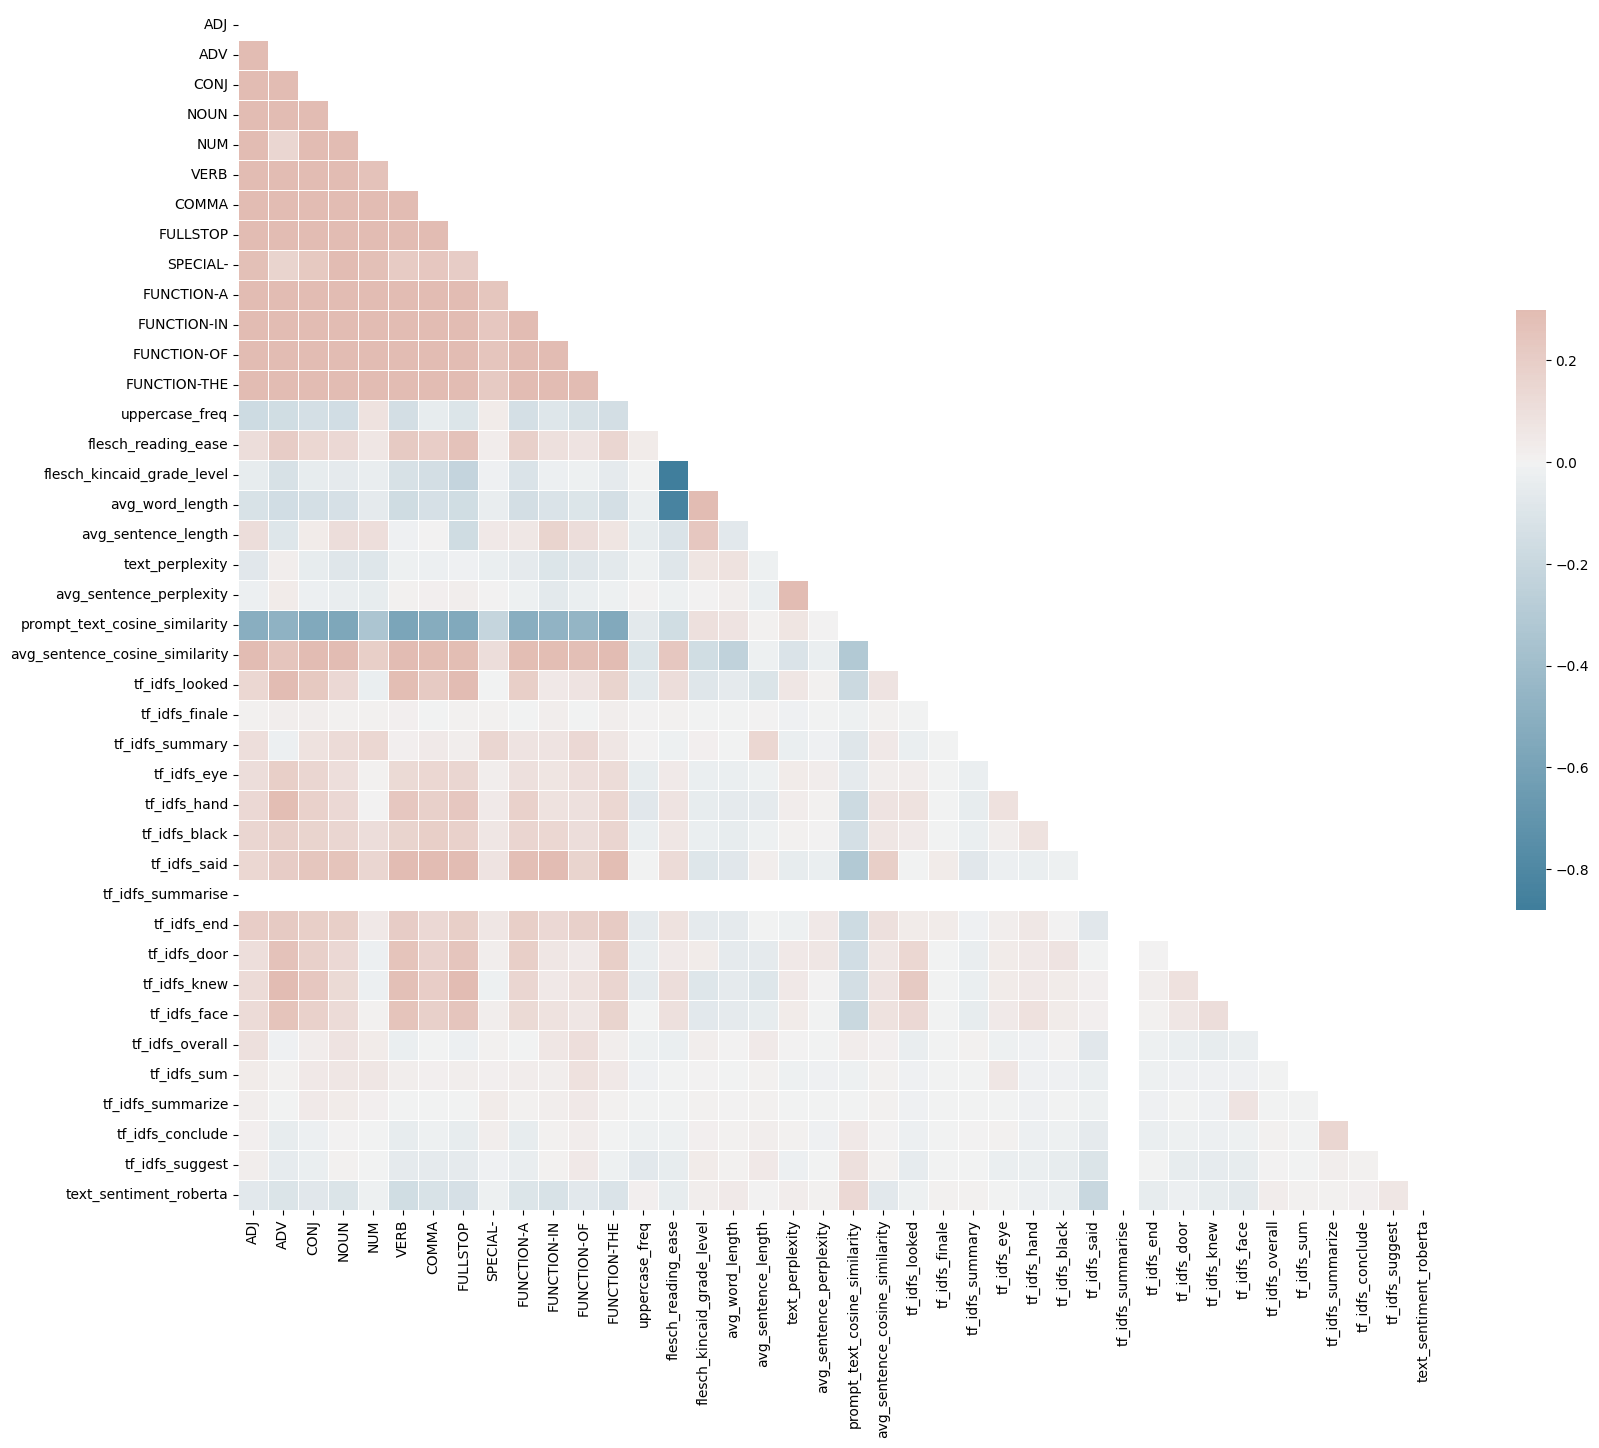

In [5]:
plot_correlation_matrix(X)

Observations - Summarise does not exist for GPT-2 while it exists fro GPT-J and GPT-3.5

Cosine similairty is positively correlated with POS

AVG word length with reading ease

# GPT J

In [6]:
# specify the name of your training dataset and load your data
training_data_name = "gpt2-large"
data_path = "data_matrix_gpt-j1x.csv"  # update this to your actual file path

# Load the data
X, y = load_data(data_path, training_data_name)

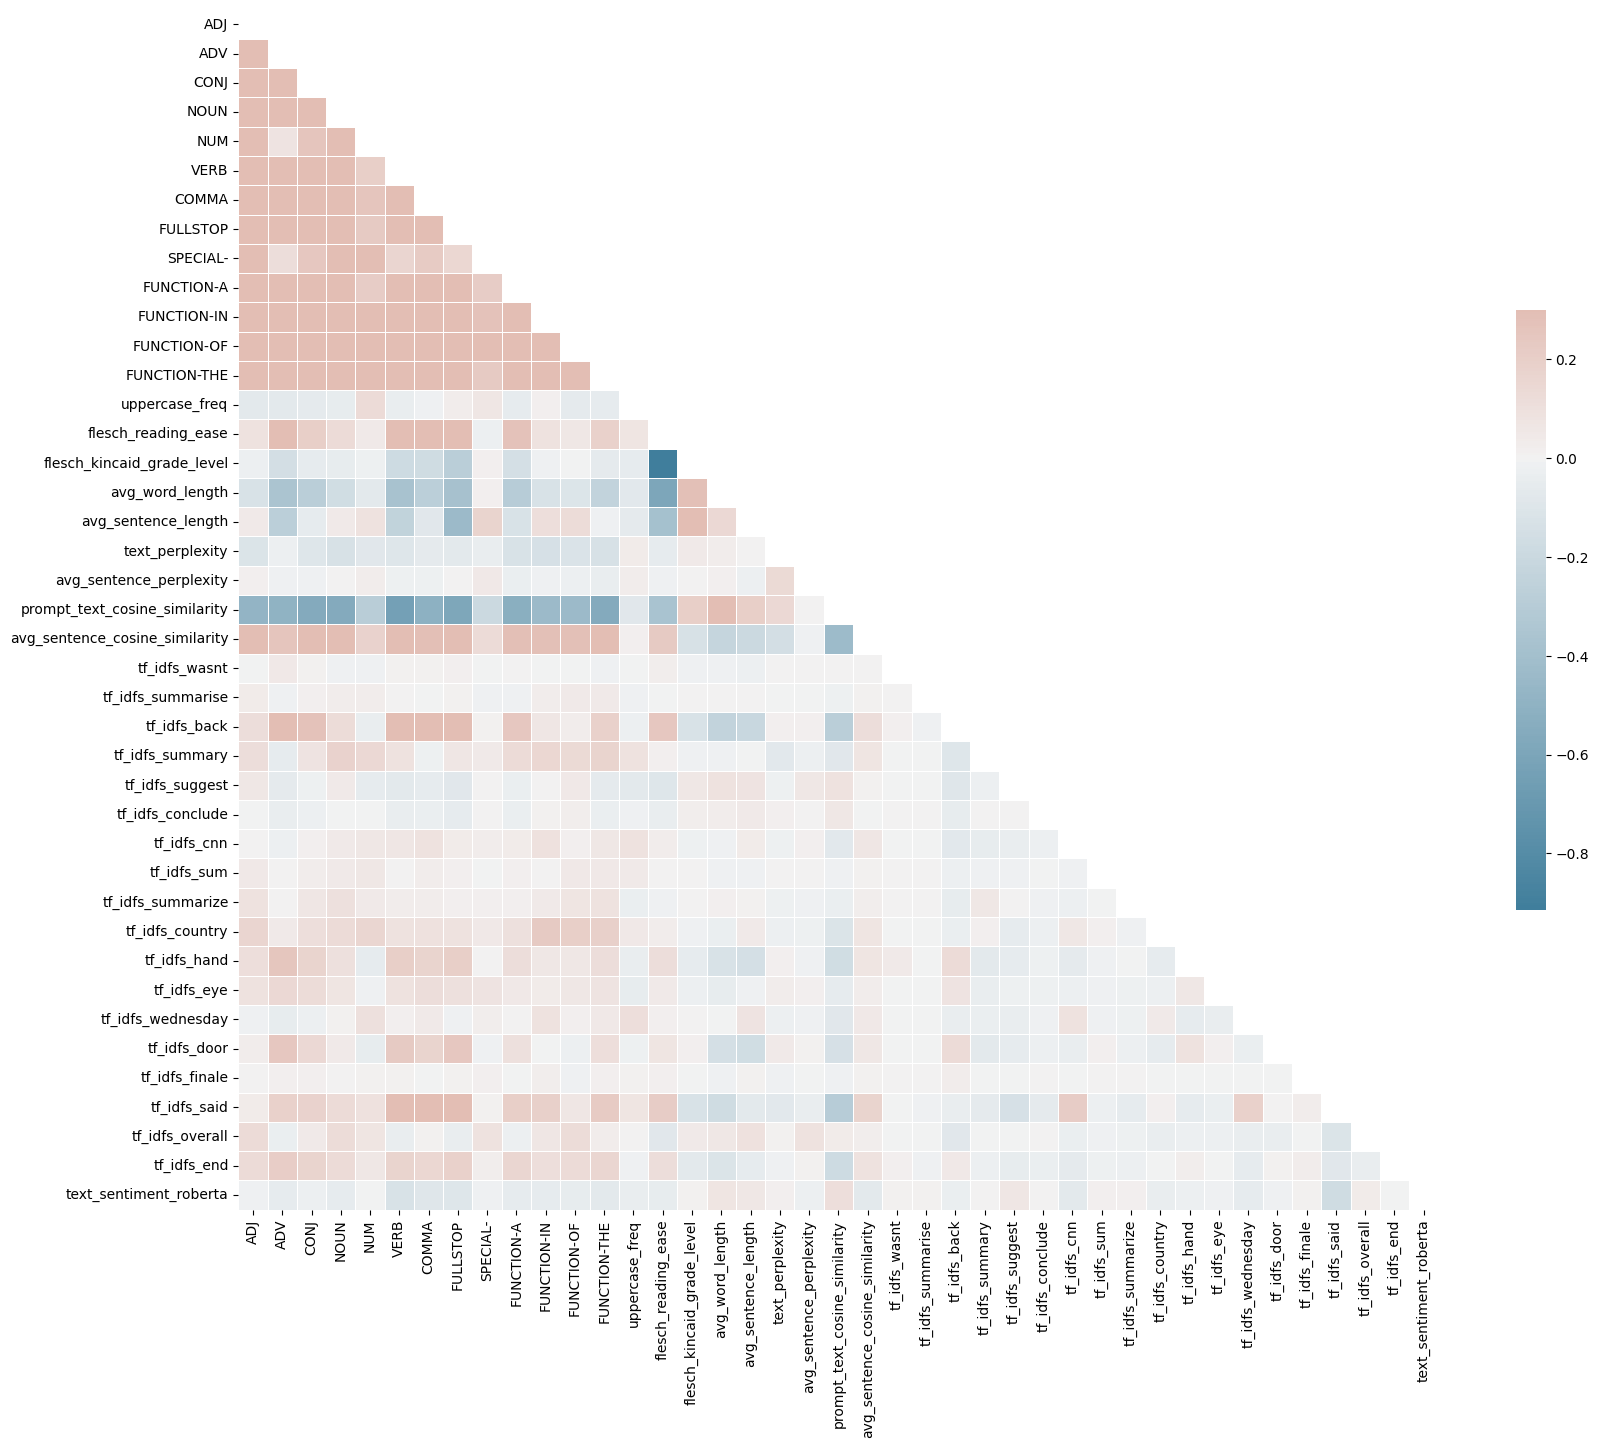

In [7]:
plot_correlation_matrix(X)

Once again summarise is barely correlated, grade level needs to go

# GPT 3.5-turbo


In [8]:
# specify the name of your training dataset and load your data
training_data_name = "gpt2-large"
data_path = "data_matrix_gpt-j1x.csv"  # update this to your actual file path

# Load the data
X, y = load_data(data_path, training_data_name)

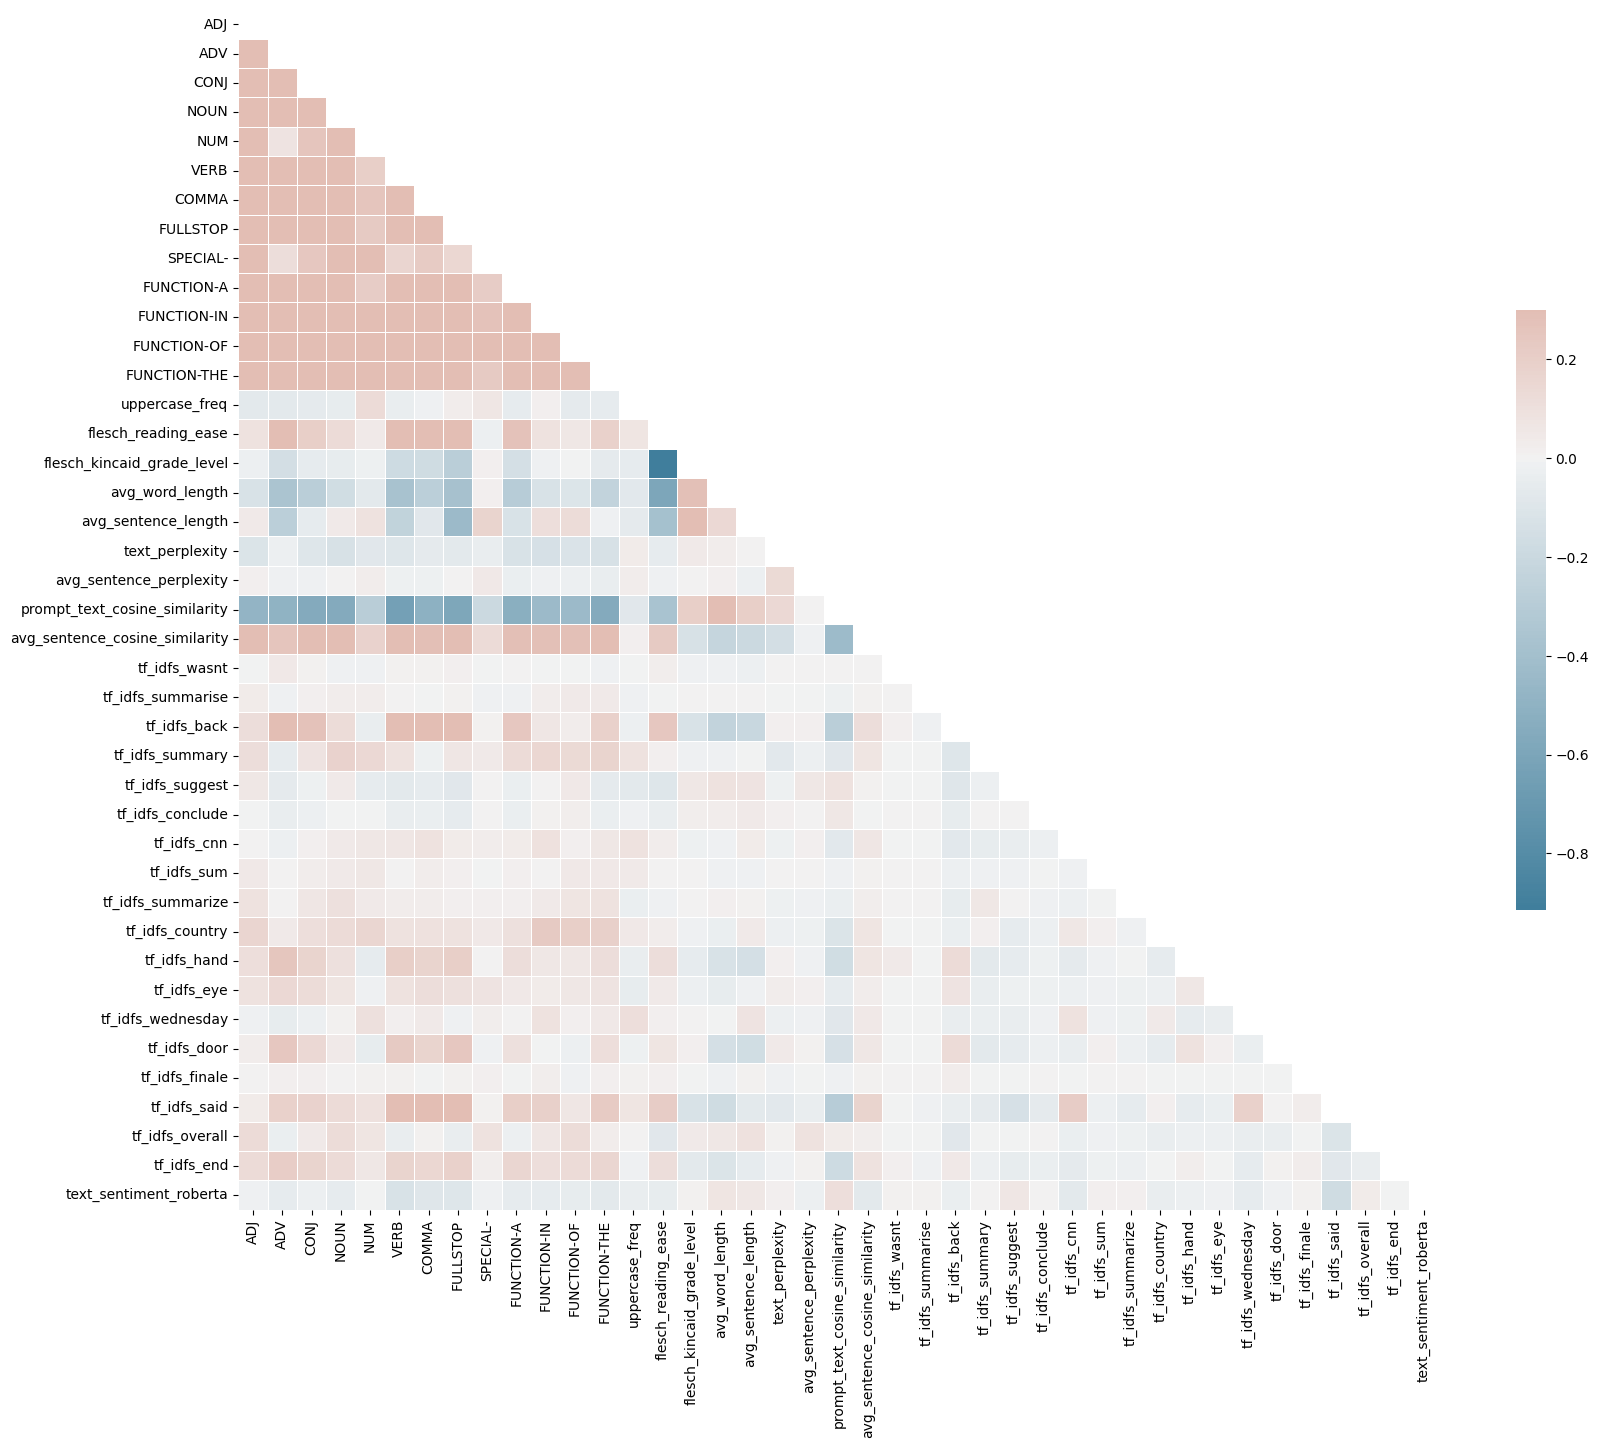

In [9]:
plot_correlation_matrix(X)

Again barely anything for summary but have to remvoe the grade level

# OVERALL: Remove Grade level accross all, remove summarise on GPT-2
# Summary words are not that well correlated - this is stupid

## With above changes:

In [82]:
# specify the name of your training dataset and load your data
training_data_name = "gpt2-large"
data_path = "logreg_test/data_matrix_gpt2-large_fixed.csv"  # update this to your actual file path

# Load the data
X, y = load_data(data_path, training_data_name)

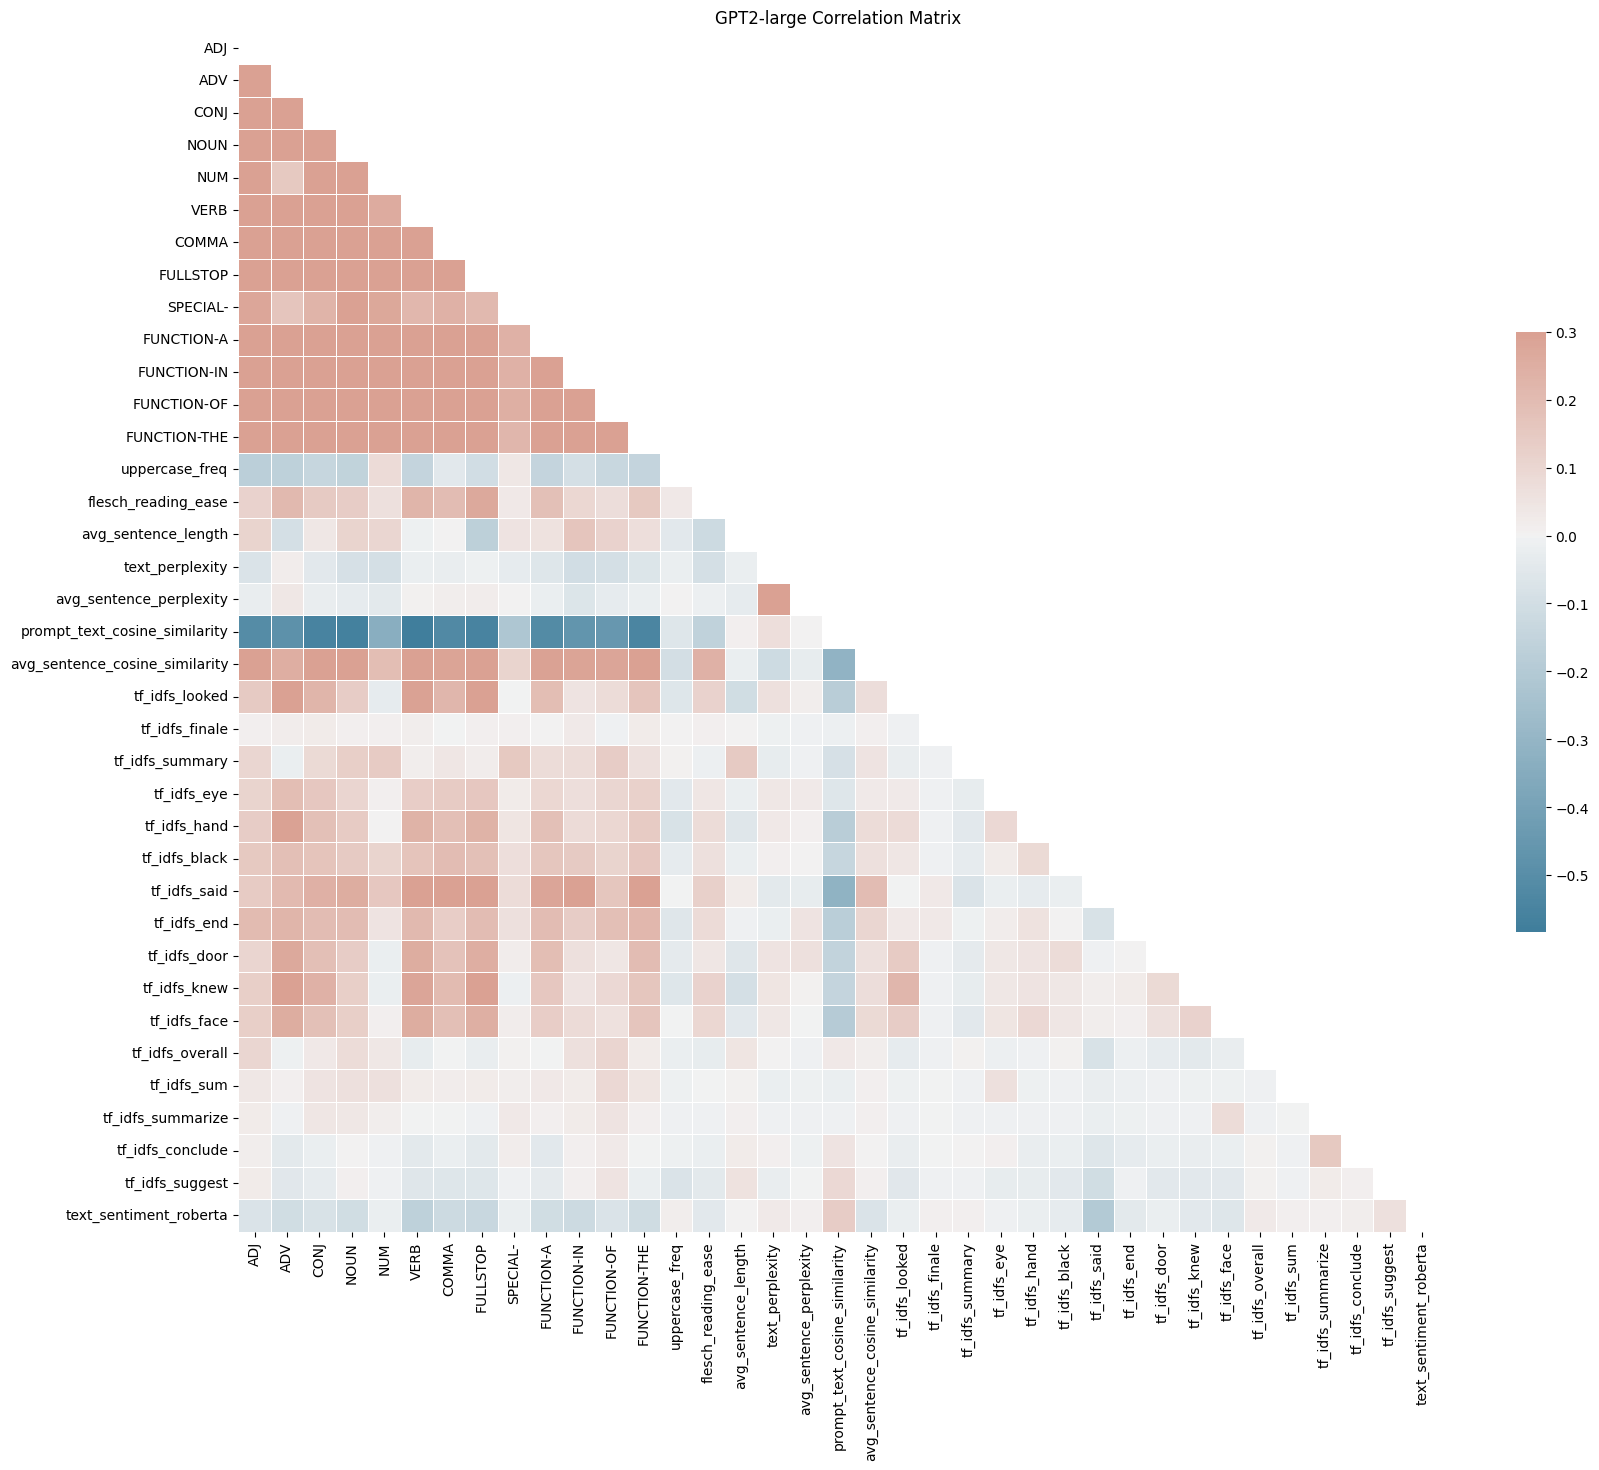

In [83]:
plot_correlation_matrix(X,"GPT2-large Correlation Matrix")

In [21]:
# specify the name of your training dataset and load your data
training_data_name = "gpt2-large"
data_path = "logreg_test/data_matrix_gpt-j1x-fixed.csv"  # update this to your actual file path

# Load the data
X, y = load_data(data_path, training_data_name)

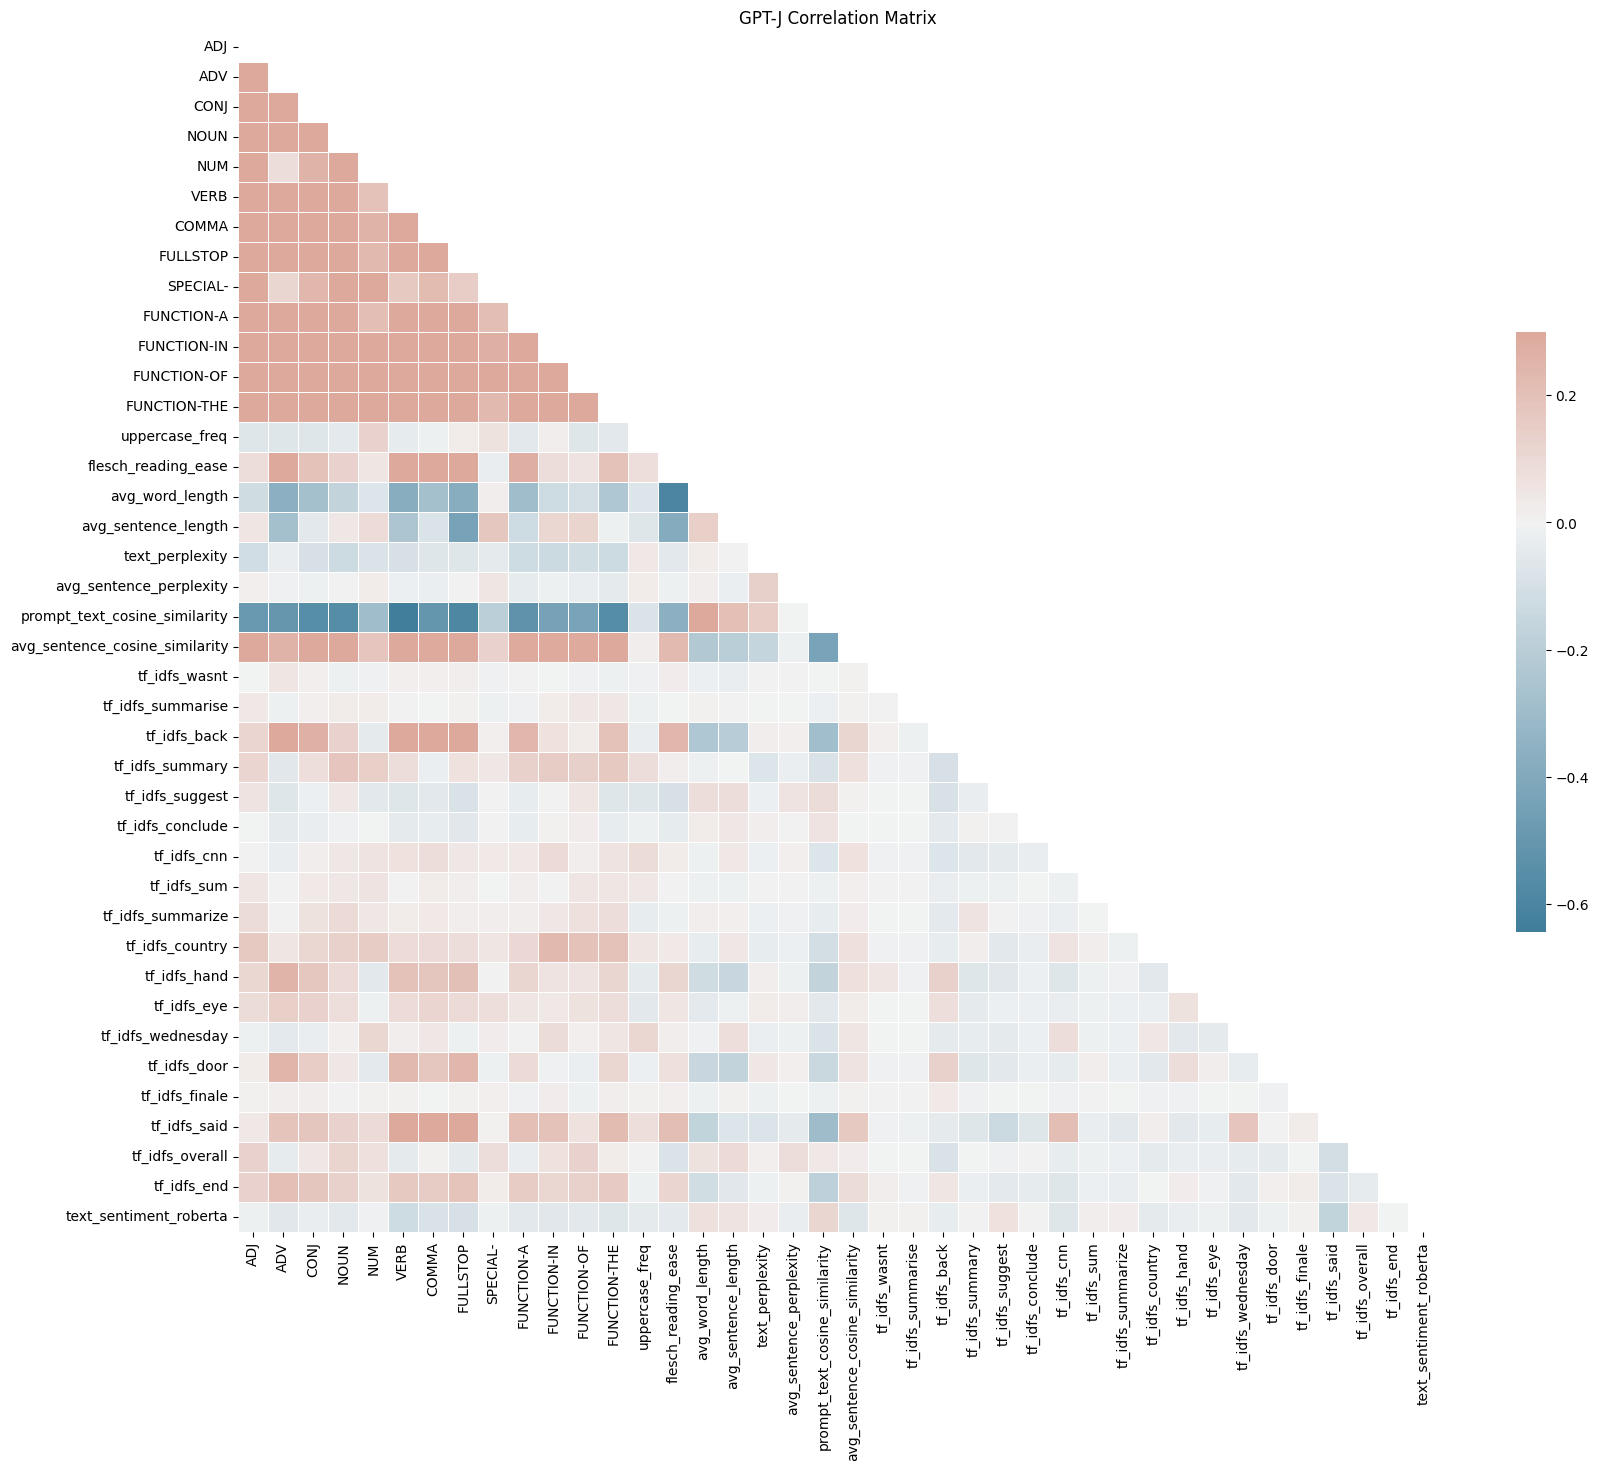

In [22]:
plot_correlation_matrix(X,"GPT-J Correlation Matrix")

In [20]:
# specify the name of your training dataset and load your data
training_data_name = "gpt2-large"
data_path = "logreg_test/data_matrix_gpt-3.5-turbo-fixed.csv"  # update this to your actual file path

# Load the data
X, y = load_data(data_path, training_data_name)

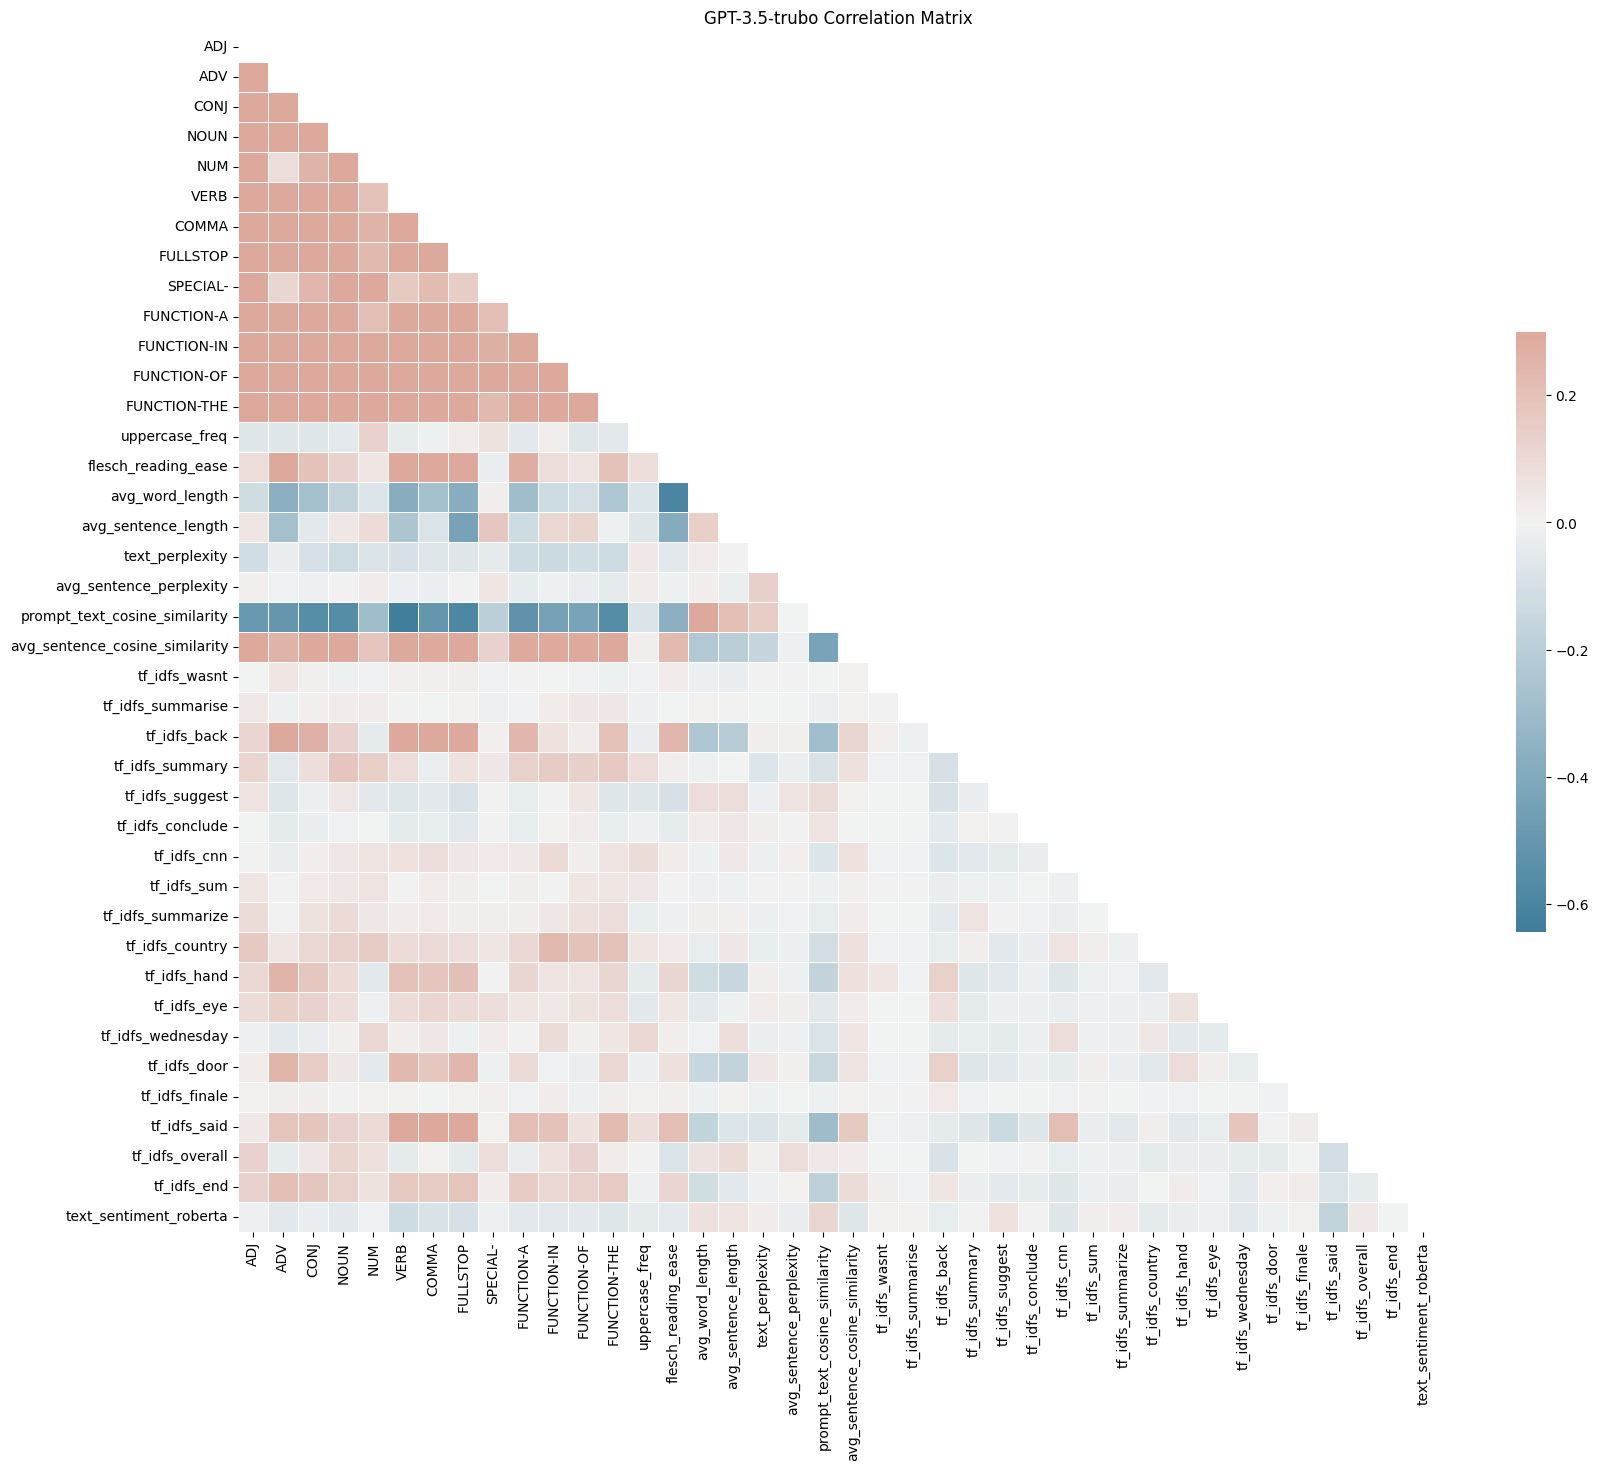

In [23]:
plot_correlation_matrix(X,"GPT-3.5-trubo Correlation Matrix")

# Now Testing the LOGREG performance

In [26]:
def print_classification_report(y_test, y_pred):
    print('Classification Report: \n', classification_report(y_test, y_pred))
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report


In [84]:
# specify the name of your training dataset and load your data
training_data_name = "gpt2-large"
data_path = "logreg_test/data_matrix_gpt2-large_fixed.csv"  # update this to your actual file path

# Load the data
X, y = load_data(data_path, training_data_name)

# Create sub-folder for each training set
if not os.path.exists(f'model_data/{training_data_name}'):
    os.makedirs(f'model_data/{training_data_name}')

# Scale and split the data
X_train_scaled, X_test_scaled, y_train, y_test = scale_and_split_data(X, y, training_data_name)

# Train logistic regression
print("Training logistic regression model...")
logreg_model = train_logreg(X_train_scaled, y_train, training_data_name)


Training logistic regression model...
Fitting 5 folds for each of 126 candidates, totalling 630 fits
Model file already exists. Do you want to overwrite it? (yes/no) yes


In [85]:
logreg_predictions = make_prediction(logreg_model, X_test_scaled)


In [86]:
print_classification_report(y_test,logreg_predictions)

Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.84      0.79       178
           1       0.78      0.67      0.72       152

    accuracy                           0.76       330
   macro avg       0.76      0.75      0.76       330
weighted avg       0.76      0.76      0.76       330



In [38]:
data_path = "data_matrix_gpt2-large.csv"  # update this to your actual file path
# Load the data
X, y = load_data(data_path, training_data_name)

# Create sub-folder for each training set
if not os.path.exists(f'model_data/{training_data_name}'):
    os.makedirs(f'model_data/{training_data_name}')

# Scale and split the data
X_train_scaled, X_test_scaled, y_train, y_test = scale_and_split_data(X, y, training_data_name)

# Train logistic regression
print("Training logistic regression model...")
logreg_model = train_logreg(X_train_scaled, y_train, training_data_name)
logreg_predictions = make_prediction(logreg_model, X_test_scaled)


Training logistic regression model...
Fitting 5 folds for each of 126 candidates, totalling 630 fits
Model file already exists. Do you want to overwrite it? (yes/no) yes


In [39]:
print_classification_report(y_test,logreg_predictions)

Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.82      0.78       178
           1       0.76      0.68      0.72       152

    accuracy                           0.76       330
   macro avg       0.76      0.75      0.75       330
weighted avg       0.76      0.76      0.76       330



In [40]:
# specify the name of your training dataset and load your data
training_data_name = "gpt2-large"
data_path = "logreg_test/data_matrix_gpt-j1x-fixed.csv"  # update this to your actual file path

# Load the data
X, y = load_data(data_path, training_data_name)

# Create sub-folder for each training set
if not os.path.exists(f'model_data/{training_data_name}'):
    os.makedirs(f'model_data/{training_data_name}')

# Scale and split the data
X_train_scaled, X_test_scaled, y_train, y_test = scale_and_split_data(X, y, training_data_name)

# Train logistic regression
print("Training logistic regression model...")
logreg_model = train_logreg(X_train_scaled, y_train, training_data_name)

Training logistic regression model...
Fitting 5 folds for each of 126 candidates, totalling 630 fits
Model file already exists. Do you want to overwrite it? (yes/no) yes


In [41]:
print_classification_report(y_test,logreg_predictions)

Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.82      0.78       178
           1       0.76      0.68      0.72       152

    accuracy                           0.76       330
   macro avg       0.76      0.75      0.75       330
weighted avg       0.76      0.76      0.76       330



In [43]:
# specify the name of your training dataset and load your data
training_data_name = "gpt2-large"
data_path = "data_matrix_gpt-j1x.csv"  # update this to your actual file path

# Load the data
X, y = load_data(data_path, training_data_name)

# Create sub-folder for each training set
if not os.path.exists(f'model_data/{training_data_name}'):
    os.makedirs(f'model_data/{training_data_name}')

# Scale and split the data
X_train_scaled, X_test_scaled, y_train, y_test = scale_and_split_data(X, y, training_data_name)

# Train logistic regression
print("Training logistic regression model...")
logreg_model = train_logreg(X_train_scaled, y_train, training_data_name)

Training logistic regression model...
Fitting 5 folds for each of 126 candidates, totalling 630 fits
Model file already exists. Do you want to overwrite it? (yes/no) yes


In [44]:
print_classification_report(y_test,logreg_predictions)

Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.82      0.78       178
           1       0.76      0.68      0.72       152

    accuracy                           0.76       330
   macro avg       0.76      0.75      0.75       330
weighted avg       0.76      0.76      0.76       330



## OVERALL 0.02 INCREASE IN ACCURACY  FROM 0.76 TO 0.78 IN ALL MODELS

# SO we use the fixed versions

## GPT2
@

In [71]:
# specify the name of your training dataset and load your data
training_data_name = "gpt2-large"
data_path = "logreg_test/data_matrix_gpt2-large_fixed.csv"  # update this to your actual file path

# Load the data
X, y = load_data(data_path, training_data_name)

# Create sub-folder for each training set
if not os.path.exists(f'model_data/{training_data_name}'):
    os.makedirs(f'model_data/{training_data_name}')

# Scale and split the data
X_train_scaled, X_test_scaled, y_train, y_test = scale_and_split_data(X, y, training_data_name)

# Train logistic regression
print("Training logistic regression model...")
logreg_model = train_logreg(X_train_scaled, y_train, training_data_name)

Training logistic regression model...
Fitting 5 folds for each of 126 candidates, totalling 630 fits
Model file already exists. Do you want to overwrite it? (yes/no) yes


In [72]:
def plot_permutation_importance(model, X_test, y_test, feature_names):
    # Calculate permutation importances
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
    sorted_idx = result.importances_mean.argsort().tolist()  # Convert to list

    # Plot the permutation importances using a boxplot
    fig, ax = plt.subplots(figsize=(10, 6))  # Increase the figsize as needed
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=[feature_names[i] for i in sorted_idx])
    ax.set_title("[GPT-2-large] Permutation Importances (test set)")
    fig.tight_layout()
    plt.show()


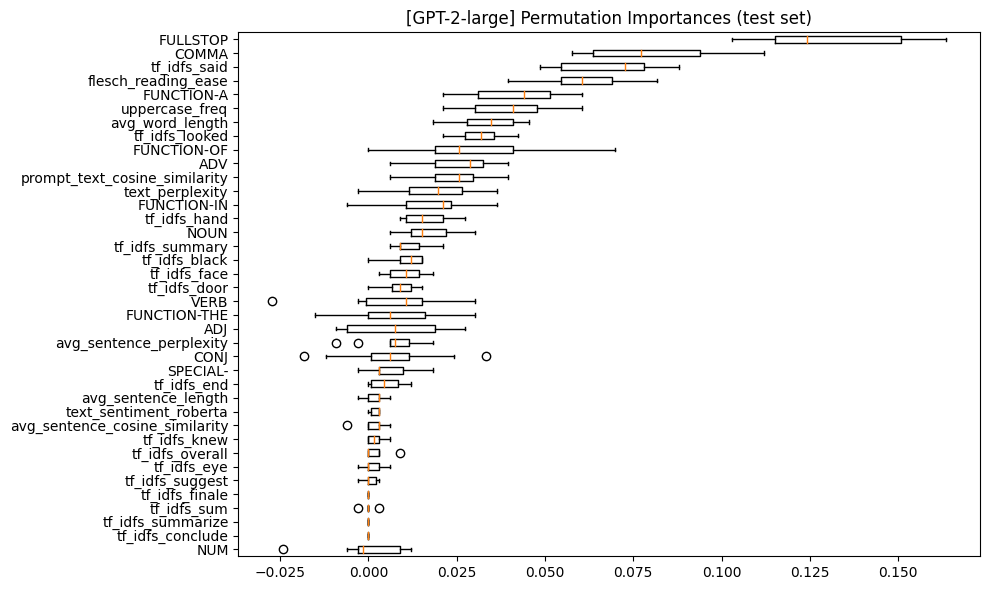

In [73]:
# Assuming you have defined the feature names in a list called 'feature_names'
feature_names = ['ADJ', 'ADV', 'CONJ', 'NOUN', 'NUM', 'VERB', 'COMMA', 'FULLSTOP', 'SPECIAL-', 'FUNCTION-A', 'FUNCTION-IN', 'FUNCTION-OF', 'FUNCTION-THE', 'uppercase_freq', 'flesch_reading_ease', 'avg_word_length', 'avg_sentence_length', 'text_perplexity', 'avg_sentence_perplexity', 'prompt_text_cosine_similarity', 'avg_sentence_cosine_similarity', 'tf_idfs_looked', 'tf_idfs_finale', 'tf_idfs_summary', 'tf_idfs_eye', 'tf_idfs_hand', 'tf_idfs_black', 'tf_idfs_said', 'tf_idfs_end', 'tf_idfs_door', 'tf_idfs_knew', 'tf_idfs_face', 'tf_idfs_overall', 'tf_idfs_sum', 'tf_idfs_summarize', 'tf_idfs_conclude', 'tf_idfs_suggest', 'text_sentiment_roberta']

plot_permutation_importance(logreg_model, X_test_scaled, y_test, feature_names)


In [75]:
training_data_name = "gpt-j1x"
data_path = "logreg_test/data_matrix_gpt-j1x-fixed.csv"  # update this to your actual file path

# Load the data
X, y = load_data(data_path, training_data_name)

# Create sub-folder for each training set
if not os.path.exists(f'model_data/{training_data_name}'):
    os.makedirs(f'model_data/{training_data_name}')

# Scale and split the data
X_train_scaled, X_test_scaled, y_train, y_test = scale_and_split_data(X, y, training_data_name)



# Train logistic regression
print("Training logistic regression model...")
logreg_model = train_logreg(X_train_scaled, y_train, training_data_name)

Training logistic regression model...
Fitting 5 folds for each of 126 candidates, totalling 630 fits
Model file already exists. Do you want to overwrite it? (yes/no) yes


In [77]:
def plot_permutation_importance(model, X_test, y_test, feature_names):
    # Calculate permutation importances
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
    sorted_idx = result.importances_mean.argsort().tolist()  # Convert to list

    # Plot the permutation importances using a boxplot
    fig, ax = plt.subplots(figsize=(10, 6))  # Increase the figsize as needed
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=[feature_names[i] for i in sorted_idx])
    ax.set_title("[GPT-J] Permutation Importances (test set)")
    fig.tight_layout()
    plt.show()


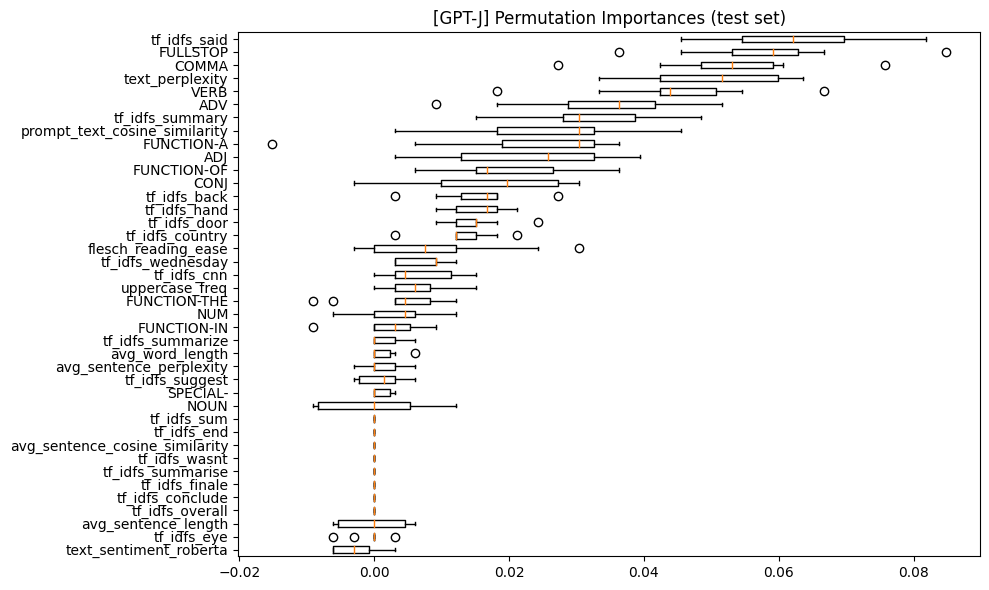

In [78]:
feature_names = ['ADJ', 'ADV', 'CONJ', 'NOUN', 'NUM', 'VERB', 'COMMA', 'FULLSTOP', 'SPECIAL-', 'FUNCTION-A', 'FUNCTION-IN', 'FUNCTION-OF', 'FUNCTION-THE', 'uppercase_freq', 'flesch_reading_ease', 'avg_word_length', 'avg_sentence_length', 'text_perplexity', 'avg_sentence_perplexity', 'prompt_text_cosine_similarity', 'avg_sentence_cosine_similarity', 'tf_idfs_wasnt', 'tf_idfs_summarise', 'tf_idfs_back', 'tf_idfs_summary', 'tf_idfs_suggest', 'tf_idfs_conclude', 'tf_idfs_cnn', 'tf_idfs_sum', 'tf_idfs_summarize', 'tf_idfs_country', 'tf_idfs_hand', 'tf_idfs_eye', 'tf_idfs_wednesday', 'tf_idfs_door', 'tf_idfs_finale', 'tf_idfs_said', 'tf_idfs_overall', 'tf_idfs_end', 'text_sentiment_roberta']



plot_permutation_importance(logreg_model, X_test_scaled, y_test, feature_names)

In [79]:
def plot_permutation_importance(model, X_test, y_test, feature_names):
    # Calculate permutation importances
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
    sorted_idx = result.importances_mean.argsort().tolist()  # Convert to list

    # Plot the permutation importances using a boxplot
    fig, ax = plt.subplots(figsize=(10, 6))  # Increase the figsize as needed
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=[feature_names[i] for i in sorted_idx])
    ax.set_title("[GPT-3.5-turbo] Permutation Importances (test set)")
    fig.tight_layout()
    plt.show()

In [80]:
training_data_name = "gpt-3.5-turbo"
data_path = "logreg_test/data_matrix_gpt-3.5-turbo-fixed.csv"  # update this to your actual file path

# Load the data
X, y = load_data(data_path, training_data_name)

# Create sub-folder for each training set
if not os.path.exists(f'model_data/{training_data_name}'):
    os.makedirs(f'model_data/{training_data_name}')

# Scale and split the data
X_train_scaled, X_test_scaled, y_train, y_test = scale_and_split_data(X, y, training_data_name)



# Train logistic regression
print("Training logistic regression model...")
logreg_model = train_logreg(X_train_scaled, y_train, training_data_name)

Training logistic regression model...
Fitting 5 folds for each of 126 candidates, totalling 630 fits
Model file already exists. Do you want to overwrite it? (yes/no) yes


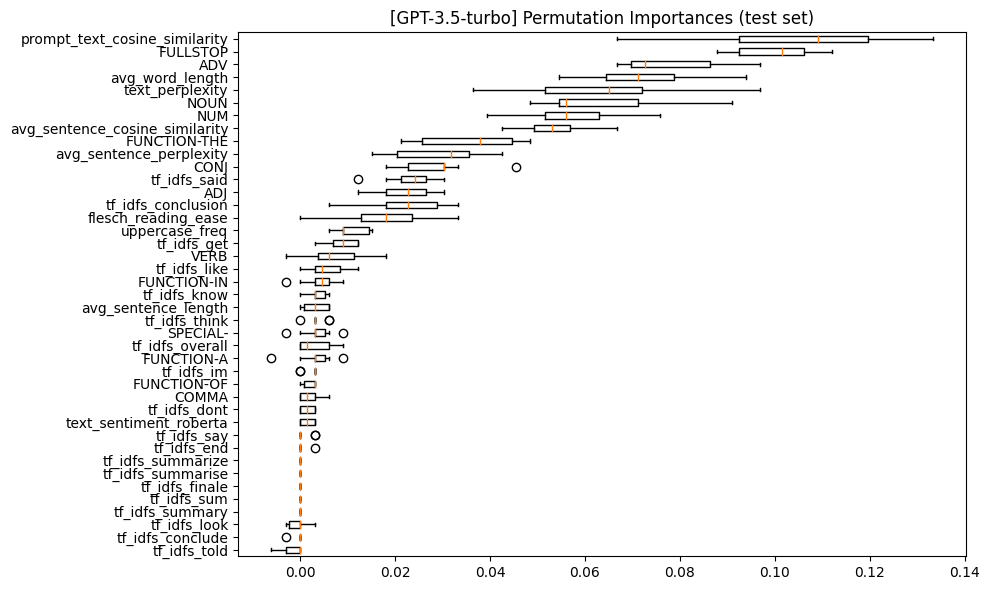

In [81]:
feature_names = ['ADJ', 'ADV', 'CONJ', 'NOUN', 'NUM', 'VERB', 'COMMA', 'FULLSTOP', 'SPECIAL-', 'FUNCTION-A', 'FUNCTION-IN', 'FUNCTION-OF', 'FUNCTION-THE', 'uppercase_freq', 'flesch_reading_ease', 'avg_word_length', 'avg_sentence_length', 'text_perplexity', 'avg_sentence_perplexity', 'prompt_text_cosine_similarity', 'avg_sentence_cosine_similarity', 'tf_idfs_get', 'tf_idfs_like', 'tf_idfs_sum', 'tf_idfs_summary', 'tf_idfs_overall', 'tf_idfs_summarize', 'tf_idfs_dont', 'tf_idfs_say', 'tf_idfs_im', 'tf_idfs_look', 'tf_idfs_said', 'tf_idfs_know', 'tf_idfs_think', 'tf_idfs_summarise', 'tf_idfs_end', 'tf_idfs_conclude', 'tf_idfs_told', 'tf_idfs_conclusion', 'tf_idfs_finale', 'text_sentiment_roberta']


plot_permutation_importance(logreg_model, X_test_scaled, y_test, feature_names)